In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

from bumps.names import *
from bumps.fitters import fit

import sasmodels
import bumps

from sasmodels.core import load_model
from sasmodels.bumps_model import Model, Experiment
from sasmodels.data import load_data, plot_data, empty_data1D
from sasmodels.direct_model import DirectModel

import sas

In [2]:
# sample meta-data
sample_info = pd.read_csv('../Sample_Info.csv')

# helpful meta-data dictionaries
names = dict(zip(sample_info['Sample'], sample_info['Name']))
cps = dict(zip(sample_info['Sample'], sample_info['Conjugated Polymer']))
matrix = dict(zip(sample_info['Sample'], sample_info['Commodity Polymer']))
solvent_names = dict(zip(sample_info['Sample'], sample_info['Solvent']))

# target weight percents of conjugated polymer
target = dict(zip(sample_info['Sample'], sample_info['Target Fraction']*100))

# fixing 401/402 and 403/404 sample pair target values for plotting colors only
target[401] = 0.5
target[402] = 0.1
target[403] = 5
target[404] = 1

# actual weight percentages
data = np.loadtxt('../../uv_vis/Corrected_wtPercents.csv', delimiter=',', skiprows=1)
actual = {}
actual_stdev = {}
actual_vol = {}
actual_stdev_vol = {}
for key, tar, act, stdev, act_vol, stdev_vol in data:
    actual[key] = act
    actual_stdev[key] = stdev
    actual_vol[key] = act_vol
    actual_stdev_vol[key] = stdev_vol
    
slds = {'RRe-P3HT':0.676,
       'RRa-P3HT':0.676,
       'P3DDT':0.316,
       'PQT-12':0.676,
       'Polystyrene-D8':6.464, # density 1.13
       'Polystyrene-H8':1.426}


In [3]:
data_dir = '../Smeared_Data_20200629/'
files = os.listdir(data_dir)
sans_data = {}
usans_data = {}
for file in files:
    if 'USANS' in file:
        key = int(file.split('_')[0][3:])
        usans_data[key] = load_data(data_dir + file)
    elif 'SANS' in file:
        key = int(file.split('_')[0][3:])
        sans_data[key] = load_data(data_dir + file)

Loading polystyrene fit information.

In [4]:
background_files = [file for file in os.listdir('../PS_Fitting/ps_fit_results/power_law_background') if 'json' in file]
backgrounds = {} # key is sample key, value is ('best', '95% confidence interval')
for file in background_files:
    data_read = pd.read_json('../PS_Fitting/ps_fit_results/power_law_background/' + file)
    key = int(file.split('_')[0][3:])
    p95 = data_read.loc['p95',str(key) + ' background']
    backgrounds[key] = (data_read.loc['best',str(key) + ' background'], p95)

In [5]:
power_law_fit_info = pd.read_json('../PS_Fitting/ps_fit_results/power_law_porod_exp_scale/PS_porod_exp_scale-err.json')
ps_scales = {}

for key, value in power_law_fit_info.items():
    if 'porod_exp' in key:
        ps_porod_exp = value['best']
        ps_porod_exp_95 = value['p95']
    else:
        key = int(key.split()[0])
        ps_scales[key] = (value['best'], value['p95'])

In [6]:
guinier_porod_fit = pd.read_json('../PS_Fitting/ps_fit_results/guinier_porod_s_scale/PS_s_scale-err.json')
rgs = {}
adjusted_scales = {}
for key, value in guinier_porod_fit.items():
    if key == 'ps s':
        ps_s = value['best']
        ps_s_95 = value['p95']
    elif 'rg' in key:
        key = int(key.split()[0])
        rgs[key] = (value['best'], value['p95'])
    elif 'scale' in key:
        key = int(key.split()[0])
        ps_scales[key] = (value['best'], value['p95'])
        
for key in rgs.keys():
    q1 = (1/rgs[key][0]) * np.sqrt((ps_porod_exp - ps_s)*(3-ps_s)/2)
    new_scale = ps_scales[key][0] * np.exp(-1*q1**2*rgs[key][0]**2/(3-ps_s)) * q1**(ps_porod_exp - ps_s)
    new_95p = np.array(ps_scales[key][1]) * np.exp(-1*q1**2*rgs[key][0]**2/(3-ps_s)) * q1**(ps_porod_exp - ps_s)
    adjusted_scales[key] = (new_scale, list(new_95p))

In [7]:
avg_rg = np.average([x[0] for x in rgs.values()])
max_rg = np.max([x[1][1] for x in rgs.values()])
min_rg = np.min([x[1][0] for x in rgs.values()])

In [8]:
avg_scale = np.average([x[0] for y, x in ps_scales.items() if y in rgs.keys()])
max_scale = np.average([x[1][1] for y, x in ps_scales.items() if y in rgs.keys()])
min_scale = np.average([x[1][0] for y, x in ps_scales.items() if y in rgs.keys()])


Loading the Porod analysis results, we will only utilize the previously determined background values to minimize the fitting here.

In [9]:
porod_files = [file for file in os.listdir('../Porod_analysis/porod_results') if 'json' in file]

for file in porod_files:
    data_read = pd.read_json('../Porod_analysis/porod_results/' + file)
    key = int(file.split('_')[0][3:])
    for column, value in data_read.items():
        if 'background' in column:
            backgrounds[key] = (value['best'], value['p95']) 

Loading fit parameters from the results directory.

In [16]:
fit_ellipsoid_scale[27]

(0.037929019845125006, [0.029998428240953, 0.038532945518007004])

102
              Parameter       mean  median    best [   68% interval] [   95% interval]
 1 102 ellipsoid equatorial radius    794(26)  788.75  786.93 [  774.6   813.7] [  760.4   832.4]
 2 102 ellipsoid polar radius    897(35)   899.6   906.8 [    862     929] [    836     964]
 3  102 ellipsoid scale 0.003367(29) 0.0033665 0.0033673 [0.003344 0.003388] [0.003323 0.003409]
10
              Parameter       mean  median    best [   68% interval] [   95% interval]
 1 10 ellipsoid equatorial radius   35(29)e3   17260   17000 [  16700   75200] [   2900   99800]
 2 10 ellipsoid polar radius  2.6(44)e3    2050    2060 [   1500    2100] [   1200   16300]
 3   10 ellipsoid scale 0.0514(89)  0.0463  0.0463 [  0.046   0.061] [  0.046   0.077]
110
              Parameter       mean  median    best [   68% interval] [   95% interval]
 1 110 ellipsoid equatorial radius 1.86(65)e3    2126    2124 [    580    2200] [    400    2430]
 2 110 ellipsoid polar radius   20(51)e3     300     300 [      0 

/Applications/anaconda/envs/sasmodels2/lib/python3.8/site-packages/bumps/dream/views.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure()
/Applications/anaconda/envs/sasmodels2/lib/python3.8/site-packages/bumps/dream/views.py:64: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure()


19
              Parameter       mean  median    best [   68% interval] [   95% interval]
 1 19 ellipsoid equatorial radius 6.97(65)e3    7048    7058 [   6960    7080] [   5730    7570]
 2 19 ellipsoid polar radius    925(72)  915.49  914.15 [  912.2   919.6] [  901.5   990.1]
 3   19 ellipsoid scale 0.0620(16) 0.06175 0.06169 [ 0.0616  0.0620] [ 0.0612  0.0651]


/Applications/anaconda/envs/sasmodels2/lib/python3.8/site-packages/bumps/dream/views.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=varplot.var_plot_size(len(all_vstats)))
/Applications/anaconda/envs/sasmodels2/lib/python3.8/site-packages/bumps/dream/views.py:40: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure()
/Applications/anaconda/envs/sasmodels2/lib/python3.8/site-packages/bumps/dream/views.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplo

206
              Parameter       mean  median    best [   68% interval] [   95% interval]
 1 206 ellipsoid equatorial radius   13(11)e3   11170   11170 [  10900   11300] [   2800   61100]
 2 206 ellipsoid polar radius  2.1(15)e3    1860    1861 [   1850    1870] [   1280    6730]
 3  206 ellipsoid scale 0.0827(41)  0.0816  0.0816 [  0.081   0.082] [  0.080   0.100]


/Applications/anaconda/envs/sasmodels2/lib/python3.8/site-packages/bumps/dream/views.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=varplot.var_plot_size(len(all_vstats)))
/Applications/anaconda/envs/sasmodels2/lib/python3.8/site-packages/bumps/dream/views.py:40: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure()
/Applications/anaconda/envs/sasmodels2/lib/python3.8/site-packages/bumps/dream/views.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplo

20
              Parameter       mean  median    best [   68% interval] [   95% interval]
 1 20 ellipsoid equatorial radius 11.6(84)e3    8910    8910 [   8600   13600] [   1400   37400]
 2 20 ellipsoid polar radius  1.6(35)e3     910     910 [    800     900] [    500   14400]
 3   20 ellipsoid scale  0.104(10)  0.0994  0.0993 [  0.099   0.115] [  0.097   0.139]


/Applications/anaconda/envs/sasmodels2/lib/python3.8/site-packages/bumps/dream/views.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=varplot.var_plot_size(len(all_vstats)))
/Applications/anaconda/envs/sasmodels2/lib/python3.8/site-packages/bumps/dream/views.py:40: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure()
/Applications/anaconda/envs/sasmodels2/lib/python3.8/site-packages/bumps/dream/views.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplo

26
              Parameter       mean  median    best [   68% interval] [   95% interval]
 1 26 ellipsoid equatorial radius   37(57)e3    7100    4800 [   5000  144000] [   5000  157000]
 2 26 ellipsoid polar radius   28(36)e3    6800   36900 [   3000   51000] [   3000  141000]
 3   26 ellipsoid scale 0.0109(16) 0.01017 0.01014 [ 0.0100  0.0135] [ 0.0095  0.0145]


/Applications/anaconda/envs/sasmodels2/lib/python3.8/site-packages/bumps/dream/views.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=varplot.var_plot_size(len(all_vstats)))
/Applications/anaconda/envs/sasmodels2/lib/python3.8/site-packages/bumps/dream/views.py:40: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure()
/Applications/anaconda/envs/sasmodels2/lib/python3.8/site-packages/bumps/dream/views.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplo

27
              Parameter       mean  median    best [   68% interval] [   95% interval]
 1 27 ellipsoid equatorial radius  168(50)e3  182100  182100 [ 174000  196000] [   9000  198000]
 2 27 ellipsoid polar radius   13(23)e3    7200    7200 [   7000    7000] [   7000  115000]
 3   27 ellipsoid scale 0.0373(23) 0.03796 0.03796 [ 0.0377  0.0384] [ 0.0305  0.0385]


/Applications/anaconda/envs/sasmodels2/lib/python3.8/site-packages/bumps/dream/views.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=varplot.var_plot_size(len(all_vstats)))
/Applications/anaconda/envs/sasmodels2/lib/python3.8/site-packages/bumps/dream/views.py:40: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure()
/Applications/anaconda/envs/sasmodels2/lib/python3.8/site-packages/bumps/dream/views.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplo

33
              Parameter       mean  median    best [   68% interval] [   95% interval]
 1 33 ellipsoid equatorial radius  4.4(34)e3    2700    2700 [   2700    7900] [   2600   13200]
 2 33 ellipsoid polar radius  112(72)e3  139200  195900 [   2000  181000] [   2000  197000]
 3   33 ellipsoid scale 0.01180(38) 0.01189 0.01191 [ 0.0116  0.0120] [ 0.0109  0.0124]


/Applications/anaconda/envs/sasmodels2/lib/python3.8/site-packages/bumps/dream/views.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=varplot.var_plot_size(len(all_vstats)))
/Applications/anaconda/envs/sasmodels2/lib/python3.8/site-packages/bumps/dream/views.py:40: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure()
/Applications/anaconda/envs/sasmodels2/lib/python3.8/site-packages/bumps/dream/views.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplo

34
              Parameter       mean  median    best [   68% interval] [   95% interval]
 1 34 ellipsoid equatorial radius   53(17)e3   54230   52940 [  51300   57600] [   7600   80000]
 2 34 ellipsoid polar radius   18(43)e3    6400    6400 [   6000    6000] [   6000  187000]
 3   34 ellipsoid scale 0.0423(12) 0.04243 0.04231 [ 0.0422  0.0427] [ 0.0387  0.0441]


/Applications/anaconda/envs/sasmodels2/lib/python3.8/site-packages/bumps/dream/views.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=varplot.var_plot_size(len(all_vstats)))
/Applications/anaconda/envs/sasmodels2/lib/python3.8/site-packages/bumps/dream/views.py:40: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure()
/Applications/anaconda/envs/sasmodels2/lib/python3.8/site-packages/bumps/dream/views.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplo

406
              Parameter       mean  median    best [   68% interval] [   95% interval]
 1 406 ellipsoid equatorial radius 0.71(23)e3   759.5   761.8 [    695     806] [    195    1009]
 2 406 ellipsoid polar radius 0.009(33)e6     200     200 [      0       0] [      0  152000]
 3  406 ellipsoid scale 508(16)e-6 0.0005106 0.0005116 [0.000501 0.000516] [0.000476 0.000532]


/Applications/anaconda/envs/sasmodels2/lib/python3.8/site-packages/bumps/dream/views.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=varplot.var_plot_size(len(all_vstats)))
/Applications/anaconda/envs/sasmodels2/lib/python3.8/site-packages/bumps/dream/views.py:40: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure()
/Applications/anaconda/envs/sasmodels2/lib/python3.8/site-packages/bumps/dream/views.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplo

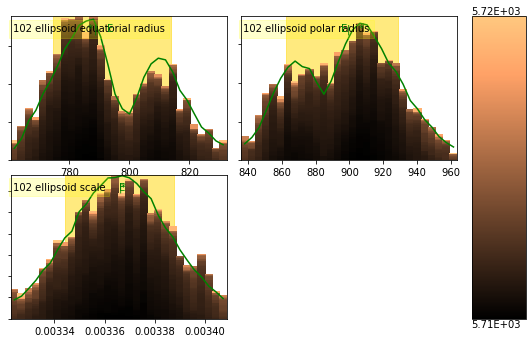

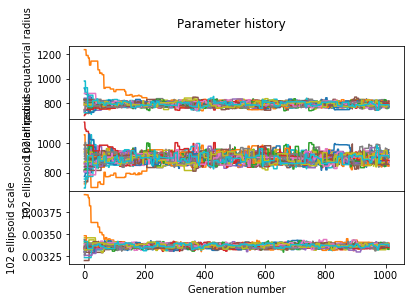

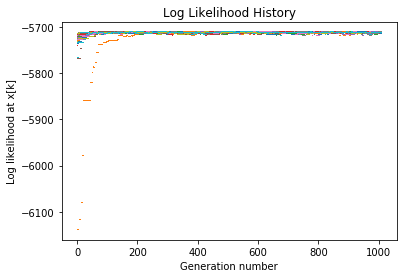

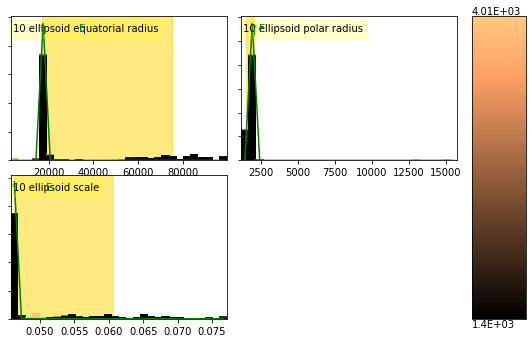

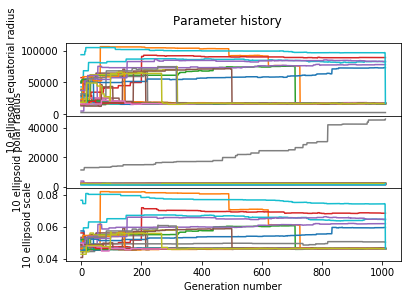

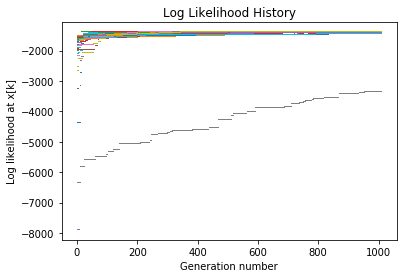

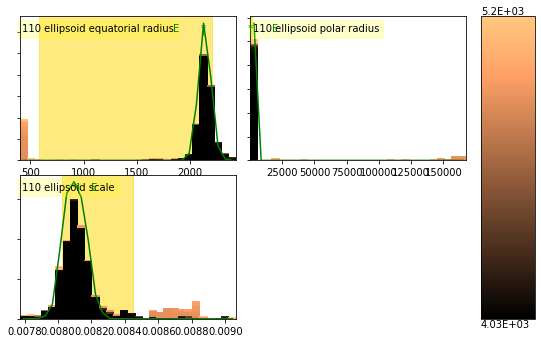

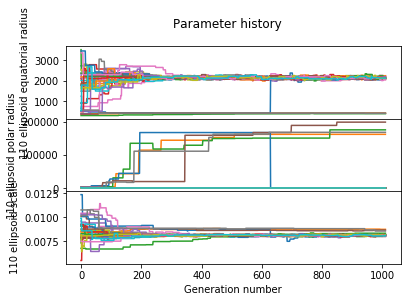

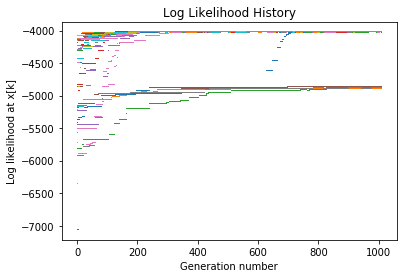

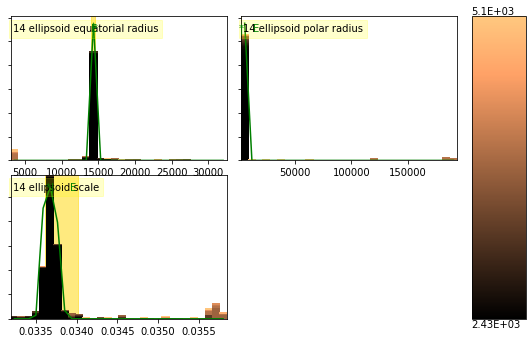

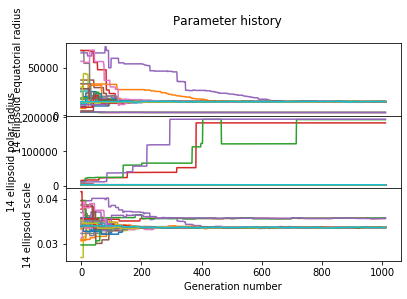

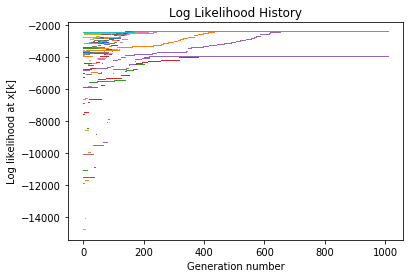

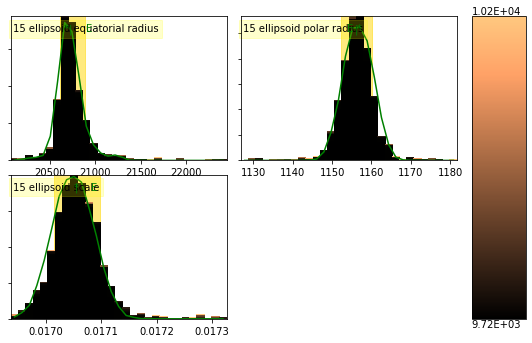

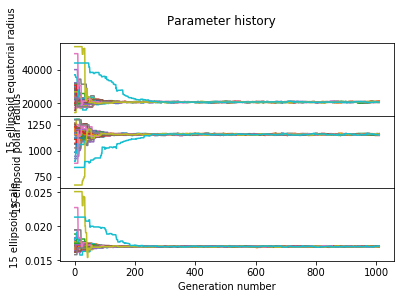

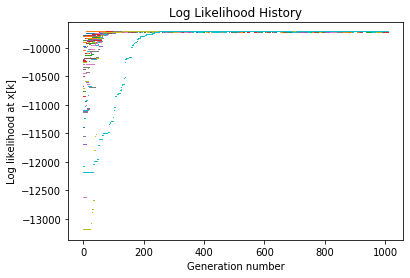

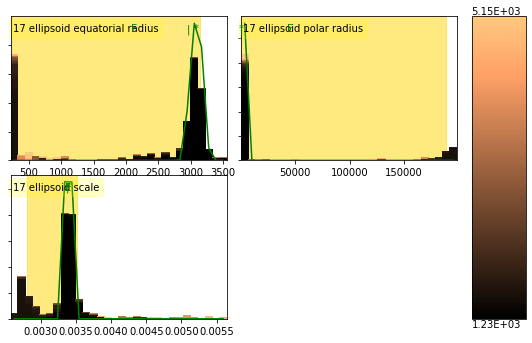

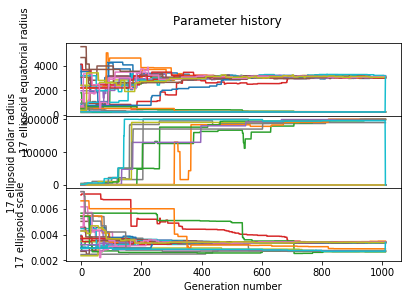

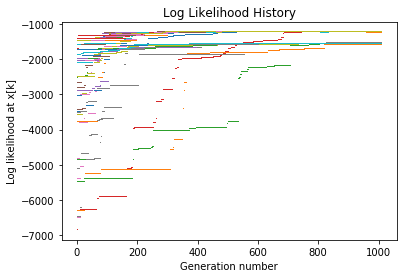

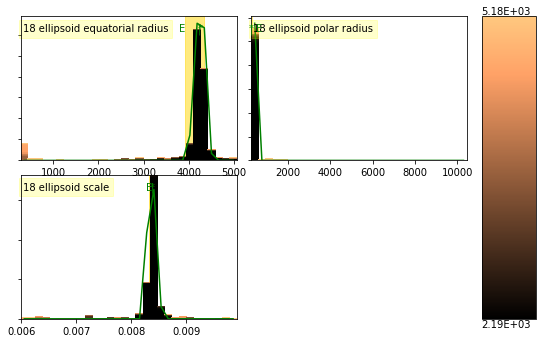

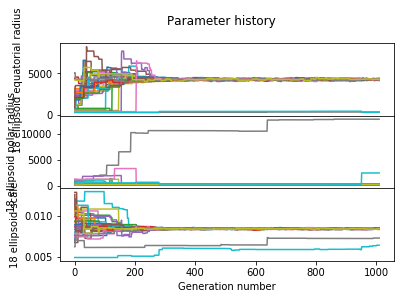

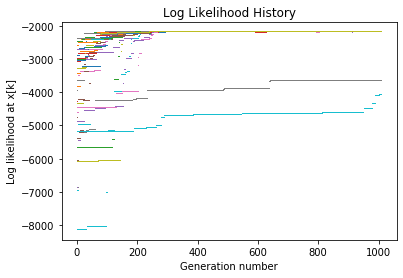

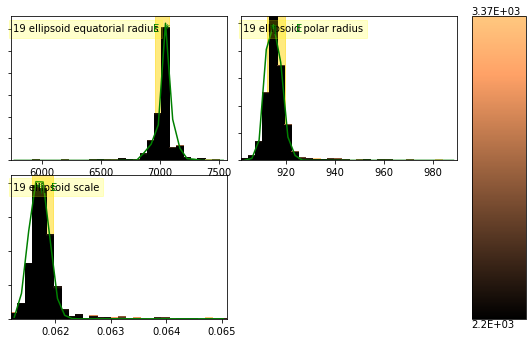

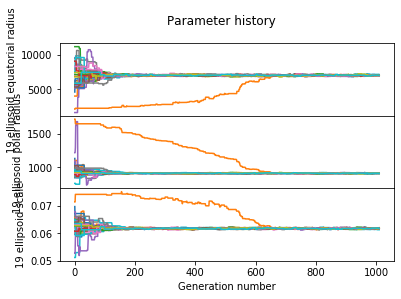

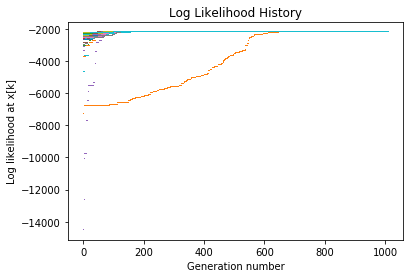

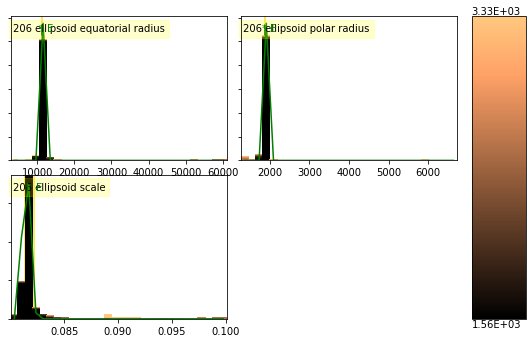

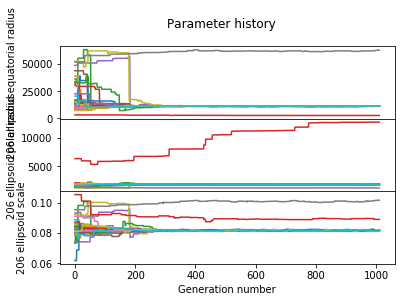

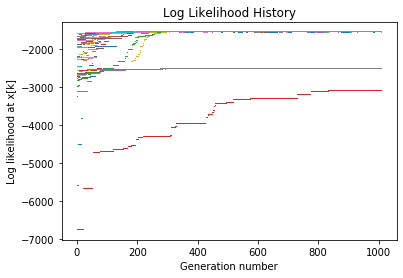

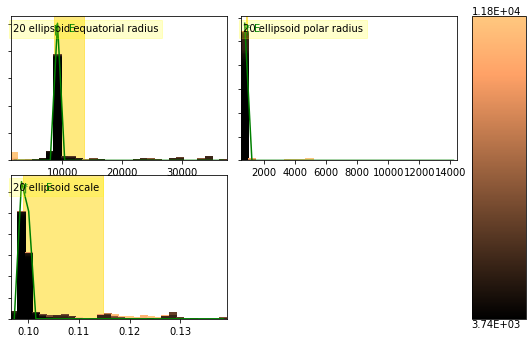

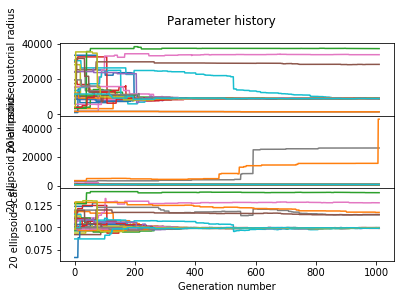

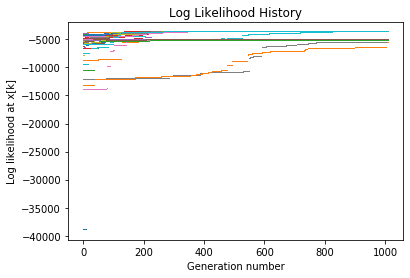

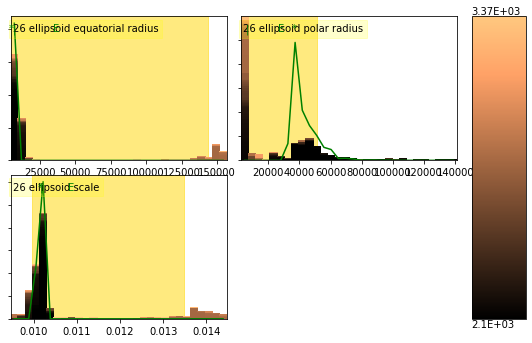

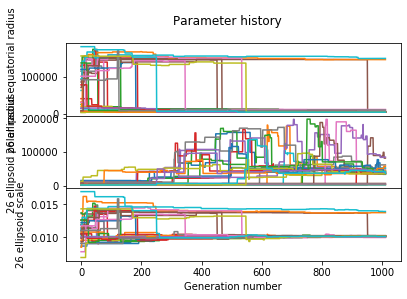

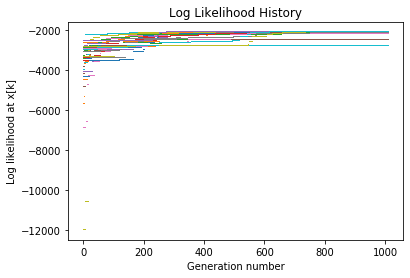

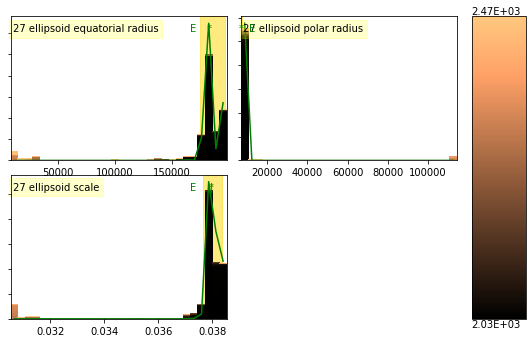

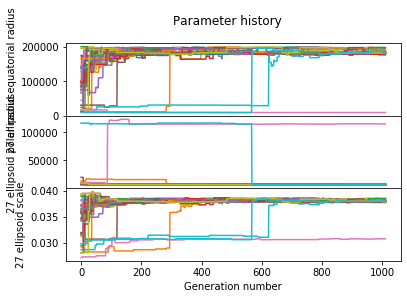

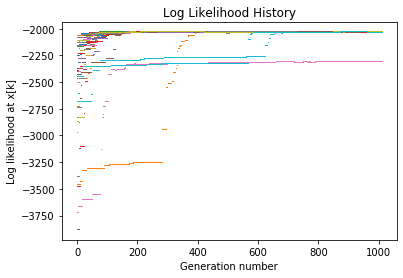

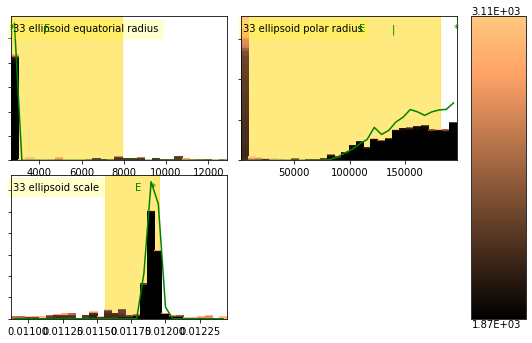

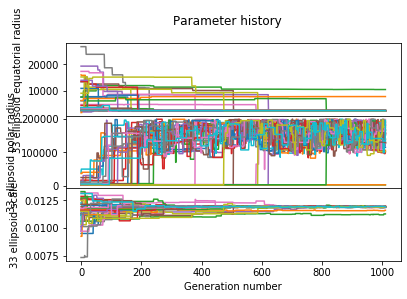

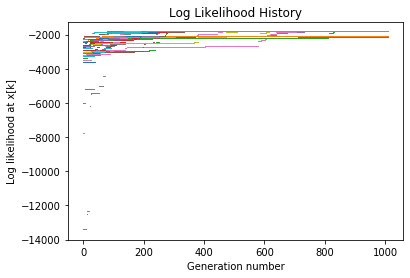

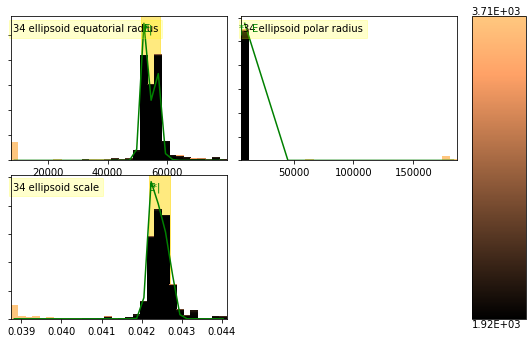

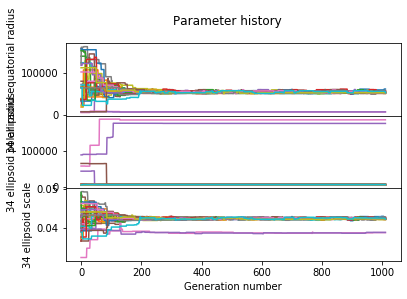

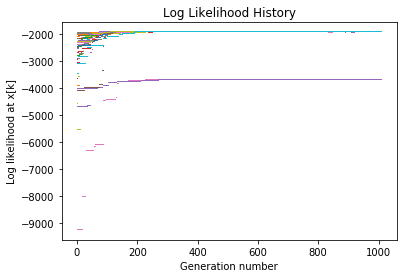

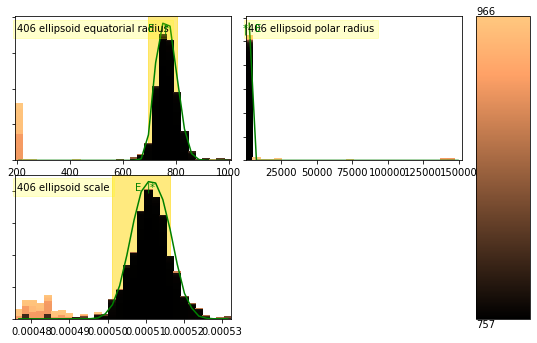

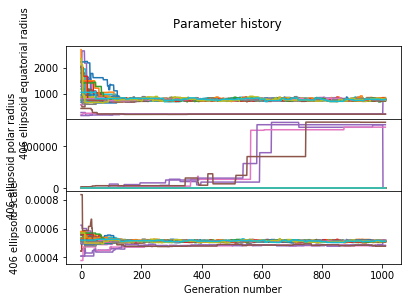

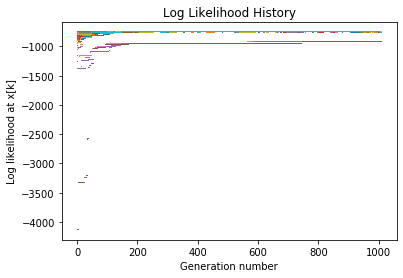

In [20]:
results_direct = 'fitting_results/ps_ellipsoid_match/'

# we will need to save the convergence plots as we had fit these on the supercomputer

for file in [file for file in os.listdir(results_direct) if 'chain' in file]:
    key = int(file.split('_')[0][3:])
    data_read = bumps.dream.state.load_state(results_direct+file[:-9])
    data_read.labels = [str(key) + ' ellipsoid equatorial radius', str(key) + ' ellipsoid polar radius', str(key) + ' ellipsoid scale'] 
    print(key)
    data_read.show(figfile=results_direct+'CMW' + str(key) + '_ps_ellipsoid')
    plt.close()

fit_keys = []
fit_ellipsoid_polar_radius = {}
fit_ellipsoid_equatorial_radius = {}
fit_ellipsoid_scale = {}

for file in [file for file in os.listdir(results_direct) if '.json' in file]:
    data_read = pd.read_json(results_direct + file)
    key = int(file.split('_')[0][3:])
    fit_keys.append(key)
    for pd_key, value in data_read.items():
#         if 'porod_exp' in pd_key:
#             best = value['best']
#             ci95 = value['p95']
#             fit_ps_porod_exp[key] = (best, ci95)
#         elif 'rg' in pd_key:
#             best = value['best']
#             ci95 = value['p95']
#             fit_ps_rg[key] = (best, ci95)
#         elif 'PS scale' in pd_key:
#             best = value['best']
#             ci95 = value['p95']
#             fit_ps_scale[key] = (best, ci95)
#         elif 'PS s' in pd_key:
#             best = value['best']
#             ci95 = value['p95']
#             fit_ps_s[key] = (best, ci95)
        if 'polar radius' in pd_key:
            best = value['best']
            ci95 = value['p95']
            fit_ellipsoid_polar_radius[key] = (best, ci95)
        elif 'equatorial radius' in pd_key:
            best = value['best']
            ci95 = value['p95']
            fit_ellipsoid_equatorial_radius[key] = (best, ci95)
        elif 'scale' in pd_key:
            best = value['best']
            ci95 = value['p95']
            fit_ellipsoid_scale[key] = (best, ci95)
        


Convenient dictionaries for plotting.

In [21]:
# useful dictionaries with labels and colors for the plots and their legends
wt_names = {} 
full_names = {}

wt_colors = {}
solvent_colors = {}
cp_colors = {}

rep_colors = {}
rep_names = {}

temp_wt_colors = {
    0.1: 'firebrick',
    0.5: 'darkorange',
    1.0: 'darkcyan',
    5.0: 'mediumblue',
    10.0: 'deeppink',
    25.0: 'darkorchid',
    50.0: 'forestgreen',
    0.0: 'black'
}

temp_solvent_colors = {
    'Chloroform': 'firebrick',
    'Bromobenzene': 'darkorange',
    'Toluene': 'darkcyan',
    'Slow Dry Chloroform': 'forestgreen'
}

temp_cp_colors = {
    'RRe-P3HT': 'firebrick',
    'RRa-P3HT': 'darkorange',
    'P3DDT': 'forestgreen',
    'PQT-12': 'darkcyan',
    'None': 'black'
}

for key in names.keys():
    if key in actual.keys():
        frac = actual[key]
    else:
        frac = target[key]
    frac = np.round(frac,2)
    
    if cps[key] == 'None':
        wt_names[key] = matrix[key] + ' Control'
        full_names[key] = matrix[key] + ' Control'
    else:
        wt_names[key] = str(frac) + ' wt% ' + cps[key]
        full_names[key] = str(frac) + ' wt% ' + cps[key] + ' in ' + matrix[key] + '\nfrom ' + solvent_names[key]
        
for key in cps.keys():
    wt_colors[key] = temp_wt_colors[target[key]]
    solvent_colors[key] = temp_solvent_colors[solvent_names[key]]
    cp_colors[key] = temp_cp_colors[cps[key]]


In [22]:
os.makedirs('fitting_figures/ps_ellipsoid_match', exist_ok=True)

for key in fit_keys:
    
    plt.figure(figsize=(6,6))
    
    kernel = load_model('guinier_porod+ellipsoid')

    vol = actual_vol[key]/100 # cp volume fraction from uv-vis
    vol_stdev = actual_stdev_vol[key]/100
    
    # model parameters
    
    scale = Parameter(1, name=str(key) + 'scale')
    background = Parameter(backgrounds[key][0], name=str(key) + 'background')
    
    A_scale = Parameter(avg_scale*(1-vol), name=str(key) + ' PS scale')
    A_rg = Parameter(avg_rg, name=str(key) + ' PS rg')
    A_s = Parameter(ps_s, name=str(key) + ' PS s')
    A_porod_exp = Parameter(ps_porod_exp, name=str(key) + ' PS porod_exp')
    
    B_scale = Parameter(fit_ellipsoid_scale[key][0], name=str(key) + ' sphere scale')
    
    B_sld = Parameter(slds[cps[key]], name=str(key) + ' PS sld')
    B_sld_solvent = Parameter(slds[matrix[key]], name=str(key) + ' PS solvent')
    
    B_radius_polar = Parameter(fit_ellipsoid_polar_radius[key][0], limits=[0,inf], name=str(key) + ' ellipsoid polar radius')
    B_radius_polar_pd = Parameter(0.5, name = str(key) + ' ellipsoid polar radius pd')
    B_radius_polar_pd_n = Parameter(200, name = str(key) + ' ellipsoid polar radius pd n')
    B_radius_polar_pd_nsigma = Parameter(8, name = str(key) + ' ellipsoid polar radius pd nsigma') 
    
    B_radius_equatorial = Parameter(fit_ellipsoid_equatorial_radius[key][0], limits=[0,inf], name=str(key) + ' ellipsoid equatorial radius')
    B_radius_equatorial_pd = Parameter(0.5, name = str(key) + ' ellipsoid equatorial radius pd')
    B_radius_equatorial_pd_n = Parameter(200, name = str(key) + ' ellipsoid equatorial radius pd n')
    B_radius_equatorial_pd_nsigma = Parameter(8, name = str(key) + ' ellipsoid equatorial radius pd nsigma') 
    
    
    # setting up the combined model for plotting
    sans_model = Model(
        model=kernel,
        scale=scale,
        background=background,
        A_scale=A_scale,
        A_rg=A_rg,
        A_s=A_s,
        A_porod_exp=A_porod_exp,
        B_scale=B_scale,
        B_sld=B_sld,
        B_sld_solvent=B_sld_solvent,
        B_radius_polar=B_radius_polar,
        B_radius_polar_pd_type='lognormal',
        B_radius_polar_pd=B_radius_polar_pd,
        B_radius_polar_pd_n=B_radius_polar_pd_n,
        B_radius_polar_pd_nsigma=B_radius_polar_pd_nsigma,
        B_radius_equatorial=B_radius_equatorial,
        B_radius_equatorial_pd_type='lognormal',
        B_radius_equatorial_pd=B_radius_equatorial_pd,
        B_radius_equatorial_pd_n=B_radius_equatorial_pd_n,
        B_radius_equatorial_pd_nsigma=B_radius_equatorial_pd_nsigma,
    )
    
    
    sans = sans_data[key]
    sans.dx = sans.dx - sans.dx
    plt.errorbar(sans.x, sans.y, yerr=sans.dy, fmt='o', c='black', zorder=1, ms=4, mfc='white', mec='black')
    
    usans = usans_data[key]
    plt.errorbar(usans.x, usans.y, yerr=usans.dy, fmt='o', c='black', zorder=1, ms=4, mfc='white', mec='black')
    
    sans_experiment=Experiment(data=sans, model=sans_model)
    usans_experiment=Experiment(data=usans, model=sans_model)

    usans_smearing = sasmodels.resolution.Slit1D(usans.x, 0.117)
    usans_experiment.resolution = usans_smearing

    sans_problem=FitProblem(sans_experiment)
    usans_problem=FitProblem(usans_experiment)
    
    plt.plot(sans.x, sans_problem.fitness.theory(), c='firebrick', linewidth=3, zorder=10)
    plt.plot(usans.x, usans_problem.fitness.theory(), c='firebrick', linewidth=3, zorder=10)

    plt.xscale('log')
    plt.yscale('log')

    plt.xlabel(r'Q ($\AA^{-1}$)', fontsize=16)
    plt.ylabel(r'I(Q) (cm$^{-1}$)', fontsize=16)

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    plt.ylim(1e-03, 1e11)
    plt.xlim(0.00002, 0.3)

    plt.title(full_names[key] + ' (Sample ' + str(key) + ')', fontsize=16)

    #plt.show()
    plt.tight_layout()
    plt.savefig('fitting_figures/ps_ellipsoid_match/CMW' + str(key) + '_PS_Ellipsoid_Fit.png', dpi=400)
    plt.close()


